In [258]:
import pandas as pd 
import seaborn as sns 
import sqlite3
import numpy as np
from plotly import express as px
with sqlite3.connect("../tickets.db") as conn: 
    cmd = \
        """
        SELECT g.*, e.price, e.extractTime, e.ticket_count FROM extraction e
        LEFT JOIN games g on e.id = g.id
        """
    df = pd.read_sql_query(cmd, conn)

# convert
df['time'], df['extractTime'] = pd.to_datetime(df['time']), pd.to_datetime(df['extractTime'])
df

,id,time,name,homeTeam,awayTeam,unique_name,price,extractTime,ticket_count
0,104722879.0,2021-06-11,Texas Rangers at Los Angeles Dodgers,Los Angeles Dodgers,Texas Rangers,Texas Rangers at Los Angeles Dodgers: 2021-06-11,58.62,2021-06-08 17:51:48.284897,0
1,104725408.0,2021-06-12,Texas Rangers at Los Angeles Dodgers,Los Angeles Dodgers,Texas Rangers,Texas Rangers at Los Angeles Dodgers: 2021-06-12,29.16,2021-06-08 17:51:48.284897,0
2,104725409.0,2021-06-13,Texas Rangers at Los Angeles Dodgers,Los Angeles Dodgers,Texas Rangers,Texas Rangers at Los Angeles Dodgers: 2021-06-13,28.04,2021-06-08 17:51:48.284897,0
3,104724531.0,2021-06-14,Philadelphia Phillies at Los Angeles Dodgers,Los Angeles Dodgers,Philadelphia Phillies,Philadelphia Phillies at Los Angeles Dodgers: ...,35.55,2021-06-08 17:51:48.284897,0
4,104725410.0,2021-06-15,Philadelphia Phillies at Los Angeles Dodgers,Los Angeles Dodgers,Philadelphia Phillies,Philadelphia Phillies at Los Angeles Dodgers: ...,24.99,2021-06-08 17:51:48.284897,0
...,...,...,...,...,...,...,...,...,...
9594,104738380.0,2021-09-29,Arizona Diamondbacks at San Francisco Giants,San Francisco Giants,Arizona Diamondbacks,Arizona Diamondbacks at San Francisco Giants: ...,20.41,2021-07-14 00:42:27.265461,2693
9595,104736599.0,2021-09-30,Arizona Diamondbacks at San Francisco Giants,San Francisco Giants,Arizona Diamondbacks,Arizona Diamondbacks at San Francisco Giants: ...,21.64,2021-07-14 00:42:27.265464,2666
9596,104736601.0,2021-10-01,San Diego Padres at San Francisco Giants,San Francisco Giants,San Diego Padres,San Diego Padres at San Francisco Giants: 2021...,33.92,2021-07-14 00:42:27.265467,2825
9597,104738382.0,2021-10-02,San Diego Padres at San Francisco Giants,San Francisco Giants,San Diego Padres,San Diego Padres at San Francisco Giants: 2021...,54.76,2021-07-14 00:42:27.265470,2940


In [259]:
# get days to game
df['days_to_game'] = (df['time'] - df['extractTime'])
df['days_to_game'] = df['days_to_game'].apply(lambda X: X.days) # subtraction is in datetime

In [260]:
df = df.dropna() # drop Na values, which were populated for days with no giants or angels
def diff_from_initial(x):
    initial = x.to_numpy()[0]
    return (x - initial)/initial
def diff_from_max(x):
    max_ = x.max()
    return (x - max_)/max_
df["diff_initial"] = df.groupby("unique_name")["price"].transform(diff_from_initial)
df["diff_max"] = df.groupby("unique_name")["price"].transform(diff_from_max)
df["pct_change"] = df.groupby("id")["price"].transform("pct_change")
df = df[df["days_to_game"] > -2]
df["days_to_game"] = df["days_to_game"] + 1

C:\Users\brill\AppData\Local\Temp/ipykernel_24488/3818656959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_initial"] = df.groupby("unique_name")["price"].transform(diff_from_initial)
C:\Users\brill\AppData\Local\Temp/ipykernel_24488/3818656959.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_max"] = df.groupby("unique_name")["price"].transform(diff_from_max)
C:\Users\brill\AppData\Local\Temp/ipykernel_24488/3818656959.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

In [261]:
dodgers = df[df['homeTeam'] == 'Los Angeles Dodgers']
giants = df[df['homeTeam'] == 'San Francisco Giants']
angels = df[df['homeTeam'] == 'Los Angeles Angels']

# Difference from initial prices

In [283]:
all_teams = df.groupby("days_to_game")[["diff_initial", "diff_max", "pct_change", "price"]].mean().reset_index()
# ex = ex[ex["days_to_game"] < 50]
# ex.to_json("../dodgers_tickets.json", orient='records')
all_teams["team"] = "all"
ex = pd.concat([all_teams, df.groupby(["homeTeam", "days_to_game"])[["diff_initial", "diff_max", "pct_change", "price"]].mean().reset_index().rename({"homeTeam": "team"}, axis=1)])
ex[ex["days_to_game"] == 0]

,days_to_game,diff_initial,diff_max,pct_change,price,team
0,0.0,-0.125929,-0.275140,0.050801,33.837159,all
0,0.0,-0.164682,-0.264530,0.124740,19.297083,Los Angeles Angels
111,0.0,-0.057808,-0.245554,0.025899,36.908065,Los Angeles Dodgers
229,0.0,-0.161738,-0.310650,0.020421,41.526970,San Francisco Giants


In [285]:
ex["diff_initial"] = ex["diff_initial"] * 100
ex["diff_max"] = ex["diff_max"] * 100
ex["pct_change"] = ex["pct_change"] * 100
ex = ex.round(2)
ex.to_json("../json/dodgers_tickets.json", orient='records')

# Difference from 7 days out

In [269]:
seven_df = df[df["days_to_game"] <= 7]
a = seven_df.groupby("unique_name")[["days_to_game"]].max().reset_index()
exclude_list = a[a["days_to_game"] < 7]["unique_name"].to_list()
exclude_list

['Arizona Diamondbacks at San Francisco Giants: 2021-06-14',
 'Philadelphia Phillies at Los Angeles Dodgers: 2021-06-14',
 'Texas Rangers at Los Angeles Dodgers: 2021-06-11',
 'Texas Rangers at Los Angeles Dodgers: 2021-06-12',
 'Texas Rangers at Los Angeles Dodgers: 2021-06-13']

In [286]:
a = seven_df.groupby("unique_name")[["days_to_game"]].max().reset_index()
exclude_list = a[a["days_to_game"] < 7]["unique_name"].to_list()
seven_df = seven_df[~seven_df["unique_name"].isin(exclude_list)]
seven_df["avg_price"] = seven_df.groupby(["homeTeam", "days_to_game"])["price"].transform(np.mean)
seven_df = seven_df.sort_values(["days_to_game", "extractTime"], ascending=False)
def diffrence_7_days(x):
    seven = x.to_numpy()[0]
    return (x - seven)/seven
seven_df["diff_7"] = seven_df.groupby("unique_name")[["avg_price"]].transform(diffrence_7_days)
seven_df

,id,time,name,homeTeam,awayTeam,unique_name,price,extractTime,ticket_count,days_to_game,diff_initial,diff_max,pct_change,avg_price,diff_7
9491,104725433.0,2021-07-21,San Francisco Giants at Los Angeles Dodgers,Los Angeles Dodgers,San Francisco Giants,San Francisco Giants at Los Angeles Dodgers: 2...,27.78,2021-07-14 00:42:26.298597,3013,7.0,-0.181014,-0.181014,0.000000,36.138462,0.000000
9380,104724577.0,2021-07-20,San Francisco Giants at Los Angeles Dodgers,Los Angeles Dodgers,San Francisco Giants,San Francisco Giants at Los Angeles Dodgers: 2...,24.34,2021-07-13 12:23:44.732320,4509,7.0,-0.352660,-0.352660,0.009959,36.138462,0.000000
9270,104724577.0,2021-07-20,San Francisco Giants at Los Angeles Dodgers,Los Angeles Dodgers,San Francisco Giants,San Francisco Giants at Los Angeles Dodgers: 2...,24.10,2021-07-13 00:47:58.155315,4596,7.0,-0.359043,-0.359043,0.002913,36.138462,0.000000
9159,104724576.0,2021-07-19,San Francisco Giants at Los Angeles Dodgers,Los Angeles Dodgers,San Francisco Giants,San Francisco Giants at Los Angeles Dodgers: 2...,52.19,2021-07-12 12:00:56.620223,4132,7.0,0.388032,-0.110297,0.160810,36.138462,0.000000
9049,104724576.0,2021-07-19,San Francisco Giants at Los Angeles Dodgers,Los Angeles Dodgers,San Francisco Giants,San Francisco Giants at Los Angeles Dodgers: 2...,44.96,2021-07-12 02:14:49.477546,4249,7.0,0.195745,-0.233549,-0.138532,36.138462,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,104725411.0,2021-06-16,Philadelphia Phillies at Los Angeles Dodgers,Los Angeles Dodgers,Philadelphia Phillies,Philadelphia Phillies at Los Angeles Dodgers: ...,28.62,2021-06-16 00:22:32.223612,2142,0.0,-0.271570,-0.278730,-0.141572,33.157826,-0.082478
2075,104736534.0,2021-06-15,Arizona Diamondbacks at San Francisco Giants,San Francisco Giants,Arizona Diamondbacks,Arizona Diamondbacks at San Francisco Giants: ...,23.35,2021-06-15 12:09:40.937214,742,0.0,-0.075614,-0.075614,0.018317,42.453871,0.011796
1980,104725410.0,2021-06-15,Philadelphia Phillies at Los Angeles Dodgers,Los Angeles Dodgers,Philadelphia Phillies,Philadelphia Phillies at Los Angeles Dodgers: ...,33.19,2021-06-15 12:09:40.068986,2140,0.0,0.328131,0.000000,0.156043,33.157826,-0.082478
1927,104736534.0,2021-06-15,Arizona Diamondbacks at San Francisco Giants,San Francisco Giants,Arizona Diamondbacks,Arizona Diamondbacks at San Francisco Giants: ...,22.93,2021-06-15 00:22:39.049277,1022,0.0,-0.092241,-0.092241,0.000000,42.453871,0.011796


In [287]:
final_seven = pd.concat([seven_df.groupby(["homeTeam", "days_to_game"])[["diff_7"]].mean().reset_index(), seven_df.groupby("days_to_game")[["diff_7"]].mean().reset_index()])
final_seven.loc[final_seven["homeTeam"].isna(), "homeTeam"] = "all"
final_seven["diff_7"] = final_seven["diff_7"] * 100
final_seven.round(2).to_json("../json/seven_days.json", orient='records')

In [72]:
idx = angels.groupby("unique_name")["days_to_game"].idxmax().to_list()
angels.iloc[idx]["price"].mean()
# dodgers[dodgers["days_to_game"] == 0]["price"].last()

25.42170212765957

# Which visiting teams draw the most?

In [52]:

visiting_df = df.copy()
def z_score(x):
    return (x - x.mean())/x.std()
visiting_df["z-score"] = visiting_df.groupby("homeTeam")[["price"]].transform(z_score)
visiting_df.groupby("awayTeam")[["z-score"]].mean().sort_values("z-score").reset_index()

,awayTeam,z-score
0,Arizona Diamondbacks,-0.826187
1,Milwaukee Brewers,-0.709951
2,St. Louis Cardinals,-0.483278
3,Colorado Rockies,-0.481343
4,Baltimore Orioles,-0.439655
5,New York Mets,-0.351498
6,Seattle Mariners,-0.337319
7,San Francisco Giants,-0.256500
8,Detroit Tigers,-0.230304
9,Texas Rangers,-0.226204


In [56]:
visiting_df["last_tracked_z-score"] = visiting_df.groupby(["unique_name"])[["z-score"]].transform("last")
visiting_df.groupby("awayTeam")[["last_tracked_z-score"]].mean().sort_values("last_tracked_z-score").reset_index()

,awayTeam,last_tracked_z-score
0,Arizona Diamondbacks,-0.966177
1,Milwaukee Brewers,-0.822857
2,Seattle Mariners,-0.791667
3,St. Louis Cardinals,-0.757857
4,Baltimore Orioles,-0.645600
5,Colorado Rockies,-0.627692
6,New York Mets,-0.617143
7,Texas Rangers,-0.460380
8,Oakland Athletics,-0.388110
9,Washington Nationals,-0.306114


In [68]:
visiting_df.groupby("awayTeam")[["z-score"]].mean().sort_values("z-score").reset_index().to_json("../json/z_score.json", orient='records')
visiting_df.groupby("awayTeam")[["last_tracked_z-score"]].mean().sort_values("last_tracked_z-score").reset_index().rename({"last_tracked_z-score": "z-score"}, axis = 1).to_json("../json/gametime_z_score.json", orient='records')

In [70]:
visiting_df["remaining_tickets"] = visiting_df.groupby("unique_name")[["ticket_count"]].transform(lambda x: x.max() - x)
visiting_df["remaining_tickets_norm"] = visiting_df.groupby("homeTeam")[["remaining_tickets"]].transform(z_score)
visiting_df.groupby("awayTeam")[["remaining_tickets_norm", "remaining_tickets"]].mean().sort_values("remaining_tickets_norm").reset_index()
visiting_df["last_remaining_tickets"] = visiting_df.groupby(["unique_name"])[["remaining_tickets_norm"]].transform("last")
a = visiting_df.groupby("awayTeam")[["last_remaining_tickets"]].last().sort_values("last_remaining_tickets").reset_index()
b = visiting_df.groupby("awayTeam")[["last_tracked_z-score"]].mean().sort_values("last_tracked_z-score").reset_index().rename({"last_tracked_z-score": "z-score"}, axis = 1)
pd.merge(a,b, on = "awayTeam").round(2)

,awayTeam,last_remaining_tickets,z-score
0,Colorado Rockies,-0.92,-0.63
1,Arizona Diamondbacks,-0.92,-0.97
2,San Diego Padres,-0.88,0.21
3,Atlanta Braves,-0.85,-0.28
4,Milwaukee Brewers,-0.85,-0.82
5,New York Mets,-0.80,-0.62
6,New York Yankees,-0.75,2.14
7,Los Angeles Angels,-0.70,0.82
8,Los Angeles Dodgers,-0.69,0.94
9,Oakland Athletics,-0.63,-0.39


In [71]:
pd.merge(a,b, on = "awayTeam").round(2).to_json("../json/supply_demand_z_scores.json", orient='records')

# When are tickets most expensive?

In [124]:
df_date = df.copy()
# df_date["date"] = df_date["time"].dt.strftime('%Y-%m-%d %s')
df_date = df_date.groupby("time")[["z-score"]].mean()
# df_date = df_date[df_date["z-score"] < 2]
df_date.reset_index().set_index("time")

,z-score
time,
2021-06-11,3.210000
2021-06-12,-0.335000
2021-06-13,-0.858000
2021-06-14,-0.772083
2021-06-15,-0.875714
...,...
2021-09-29,-0.721986
2021-09-30,-0.629589
2021-10-01,-0.233288


In [133]:
df_date.sort_values("z-score")

,z-score
time,
2021-06-23,-1.007333
2021-09-14,-0.946575
2021-06-15,-0.875714
2021-06-13,-0.858000
2021-07-18,-0.830137
...,...
2021-09-11,1.074932
2021-08-07,1.316986
2021-08-04,2.804932


(<Figure size 1728x216 with 2 Axes>,
 array([<AxesSubplot:ylabel='2021'>], dtype=object))

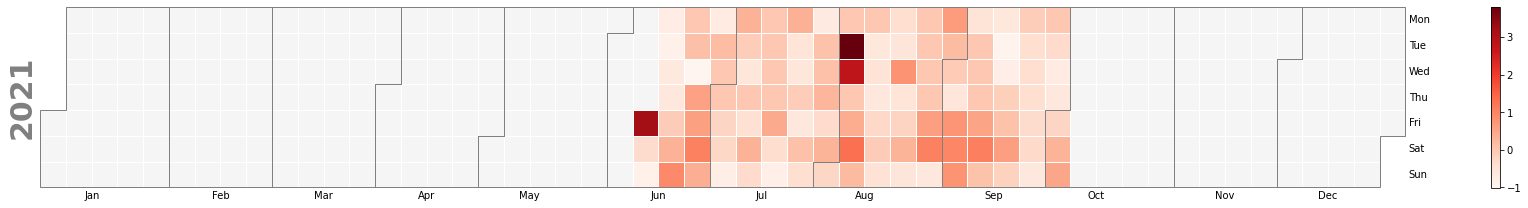

In [132]:
import calplot

calplot.calplot(df_date["z-score"], cmap = "Reds", figsize=(24,3))

In [88]:
b = df_date.groupby("date")[["z-score"]].mean().reset_index().rename({"z-score" : "value"}, axis = 1)
b["name"] = "z-score"
b.to_json("../json/z_score_by_time.json", orient='records')

In [82]:
df["time"].dt.strftime('%Y-%m-%d %s')

0       2021-06-11 00:00:00
1       2021-06-12 00:00:00
2       2021-06-13 00:00:00
3       2021-06-14 00:00:00
4       2021-06-15 00:00:00
               ...         
9594    2021-09-29 00:00:00
9595    2021-09-30 00:00:00
9596    2021-10-01 00:00:00
9597    2021-10-02 00:00:00
9598    2021-10-03 00:00:00
Name: time, Length: 9566, dtype: object

# ML?

In [220]:
training_df = df[["homeTeam", "awayTeam", "price", "ticket_count", "days_to_game",]].reset_index()
# training_df = df[["days_to_game", "z-score"]]
y = training_df["price"]
X = training_df.drop(["price", "index"], axis = 1)
# X["time"] = X["time"].dt.strftime('%Y-%m-%d')
X

,homeTeam,awayTeam,ticket_count,days_to_game
0,Los Angeles Dodgers,Texas Rangers,0,3.0
1,Los Angeles Dodgers,Texas Rangers,0,4.0
2,Los Angeles Dodgers,Texas Rangers,0,5.0
3,Los Angeles Dodgers,Philadelphia Phillies,0,6.0
4,Los Angeles Dodgers,Philadelphia Phillies,0,7.0
...,...,...,...,...
9561,San Francisco Giants,Arizona Diamondbacks,2693,77.0
9562,San Francisco Giants,Arizona Diamondbacks,2666,78.0
9563,San Francisco Giants,San Diego Padres,2825,79.0
9564,San Francisco Giants,San Diego Padres,2940,80.0


In [221]:
from sklearn.preprocessing import OneHotEncoder
away_enc = OneHotEncoder(categories = "auto", sparse = False, handle_unknown = "ignore")
home_enc = OneHotEncoder(categories = "auto", sparse = False, handle_unknown = "ignore")
away_enc.fit(X["awayTeam"].to_numpy().reshape(-1, 1))
home_enc.fit(X["homeTeam"].to_numpy().reshape(-1, 1))
away_dummies = pd.DataFrame(away_enc.transform(X["awayTeam"].to_numpy().reshape(-1, 1)), columns = away_enc.get_feature_names(["away"]))
home_dummies = pd.DataFrame(home_enc.transform(X["homeTeam"].to_numpy().reshape(-1, 1)), columns = home_enc.get_feature_names(["home"]))
X = pd.concat([X, away_dummies, home_dummies], axis = 1).drop(["awayTeam", "homeTeam"], axis = 1)
X

,ticket_count,days_to_game,away_Arizona Diamondbacks,away_Atlanta Braves,away_Baltimore Orioles,away_Boston Red Sox,away_Chicago Cubs,away_Colorado Rockies,away_Detroit Tigers,away_Houston Astros,...,away_San Diego Padres,away_San Francisco Giants,away_Seattle Mariners,away_St. Louis Cardinals,away_Texas Rangers,away_Toronto Blue Jays,away_Washington Nationals,home_Los Angeles Angels,home_Los Angeles Dodgers,home_San Francisco Giants
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9561,2693,77.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9562,2666,78.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9563,2825,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9564,2940,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [217]:
away_dummies = pd.get_dummies(X["awayTeam"], prefix = "awayTeam")
home_dummies = pd.get_dummies(X["homeTeam"], prefix = "homeTeam")
X = pd.concat([X, away_dummies, home_dummies], axis = 1).drop(["awayTeam", "homeTeam"], axis = 1)
X

,index,ticket_count,days_to_game,awayTeam_Arizona Diamondbacks,awayTeam_Atlanta Braves,awayTeam_Baltimore Orioles,awayTeam_Boston Red Sox,awayTeam_Chicago Cubs,awayTeam_Colorado Rockies,awayTeam_Detroit Tigers,...,awayTeam_San Diego Padres,awayTeam_San Francisco Giants,awayTeam_Seattle Mariners,awayTeam_St. Louis Cardinals,awayTeam_Texas Rangers,awayTeam_Toronto Blue Jays,awayTeam_Washington Nationals,homeTeam_Los Angeles Angels,homeTeam_Los Angeles Dodgers,homeTeam_San Francisco Giants
0,0,0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,2,0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,3,0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9561,9594,2693,77.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9562,9595,2666,78.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9563,9596,2825,79.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9564,9597,2940,80.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [222]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X, y)
LR.score(X, y)


0.61376283416149

In [232]:
from sklearn.feature_selection import f_classif
f_classif(X,y)
from sklearn.feature_selection import SelectKBest
KBest = SelectKBest(LR.score, k = 5)
KBest.fit(X, y)

SelectKBest(k=5,
            score_func=<bound method RegressorMixin.score of LinearRegression()>)

In [243]:
home_team = "Los Angeles Dodgers"
away_team = "San Francisco Giants"
days_to_game = 0
ticket_count = 3000
predict = np.concatenate([np.array([days_to_game, ticket_count]), away_enc.transform(np.array([away_team]).reshape(1, -1)).ravel(), home_enc.transform(np.array([home_team]).reshape(1, -1)).ravel()])
LR.predict(predict.reshape(-1,1))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 28 is different from 1)

In [227]:
home_enc.transform(np.array(["Los Angeles Dodgers"]).reshape(1, -1))

array([[0., 1., 0.]])

In [240]:
away_enc.transform(np.array([away_team]).reshape(-1, 1)).ravel().shape

(23,)